<a href="https://colab.research.google.com/github/Rishikesh23a/Emotion-Recognition-from-Speech/blob/main/Emotion_Recognition_from_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download & Extract the Dataset

In [ ]:
!wget "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1" -O Audio_Speech_Actors_01-24.zip

import zipfile
with zipfile.ZipFile("Audio_Speech_Actors_01-24.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/emotion_dataset")
print("✅ Dataset Extracted!")


--2025-06-28 09:50:42--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2025-06-28 09:50:43--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M   864KB/s    in 3m 55s  

2025-06-28 09:54:38 (867 KB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]

✅ Dataset Extracted!


Install Required Libraries

In [ ]:
!pip install librosa soundfile resampy numpy scikit-learn matplotlib tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.8 MB/s eta 0:00:00


Feature Extraction (MFCCs)

In [ ]:
import librosa
import numpy as np
import os

emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

def extract_features(file_path, max_len=174):
    audio, sr = librosa.load(file_path, sr=None)  # avoids resampy issues
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    pad_width = max_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

X, y = [], []

for root, _, files in os.walk("/content/emotion_dataset"):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion_code = file.split("-")[2]
            label = emotion_map.get(emotion_code)
            if label:
                features = extract_features(file_path)
                X.append(features)
                y.append(label)

X = np.array(X)
y = np.array(y)

print("✅ Features extracted:", X.shape)
print("🎯 Labels found:", set(y))


✅ Features extracted: (1440, 40, 174)
🎯 Labels found: {np.str_('angry'), np.str_('happy'), np.str_('disgust'), np.str_('sad'), np.str_('surprised'), np.str_('calm'), np.str_('fearful'), np.str_('neutral')}


Encode Labels & Split Data

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # for CNN input

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("📐 Train shape:", X_train.shape)
print("📐 Test shape:", X_test.shape)


📐 Train shape: (1152, 40, 174, 1)
📐 Test shape: (288, 40, 174, 1)


Build and Train CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40, 174, 1)),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,752,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,772,488 (10.58 MB)

 Trainable params: 2,772,488 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 328ms/step - accuracy: 0.1202 - loss: 51.2018 - val_accuracy: 0.1424 - val_loss: 2.0527
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.1393 - loss: 2.0817 - val_accuracy: 0.1562 - val_loss: 2.0445
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.1673 - loss: 2.0733 - val_accuracy: 0.1424 - val_loss: 2.0477
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.1666 - loss: 2.0641 - val_accuracy: 0.1597 - val_loss: 2.0408
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step - accuracy: 0.1753 - loss: 2.0525 - val_accuracy: 0.1389 - val_loss: 2.0465
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 338ms/step - accuracy: 0.2168 - loss: 2.0273 - val_accuracy: 0.2500 - val_loss: 1.9689
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 413ms/step - accuracy: 0.1972 - loss: 2.0043 - val_accuracy: 0.1910 - val_loss: 1.9665
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step - accuracy: 0.2477 - loss: 1.9927 - val_acc

Evaluate and Visualize

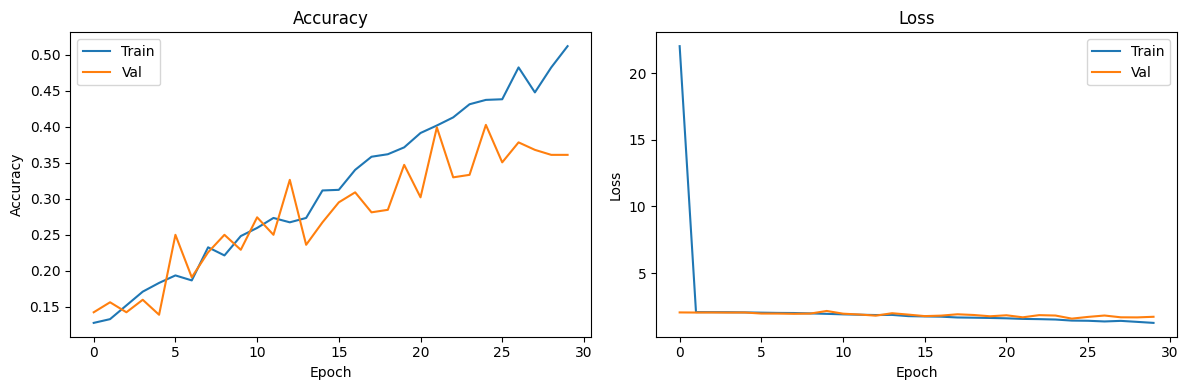

In [ ]:
import matplotlib.pyplot as plt

# Accuracy & Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Final Accuracy

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4143 - loss: 1.6260
✅ Final Test Accuracy: 36.11%


a Confusion Matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


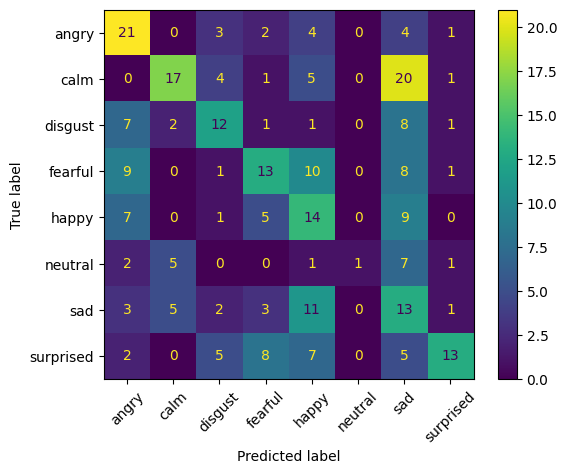

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.show()


EarlyStopping or ModelCheckpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)


Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5492 - loss: 1.1799

36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.5488 - loss: 1.1811 - val_accuracy: 0.3715 - val_loss: 1.6647
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.5477 - loss: 1.1908 - val_accuracy: 0.3854 - val_loss: 1.6998
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5671 - loss: 1.1334

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.5667 - loss: 1.1346 - val_accuracy: 0.4028 - val_loss: 1.6622
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - accuracy: 0.5549 - loss: 1.1572 - val_accuracy: 0.3819 - val_loss: 1.7916
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.5659 - loss: 1.1230 - val_accuracy: 0.4132 - val_loss: 1.7974
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - accuracy: 0.6074 - loss: 1.0767 - val_accuracy: 0.3819 - val_loss: 1.7106
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.6176 - loss: 1.0124 - val_accuracy: 0.3889 - val_loss: 1.7029
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5915 - loss: 1.0499

36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.5914 - loss: 1.0497 - val_accuracy: 0.4514 - val_loss: 1.5701
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.6094 - loss: 1.0346 - val_accuracy: 0.4132 - val_loss: 1.8290
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.6330 - loss: 0.9829 - val_accuracy: 0.4132 - val_loss: 1.8240
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6392 - loss: 0.9387

36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.6391 - loss: 0.9397 - val_accuracy: 0.4236 - val_loss: 1.5324
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - accuracy: 0.6535 - loss: 0.9114 - val_accuracy: 0.4271 - val_loss: 1.6994
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.6398 - loss: 0.9228 - val_accuracy: 0.4028 - val_loss: 1.6312
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.6310 - loss: 0.9226 - val_accuracy: 0.4201 - val_loss: 1.6931
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.6514 - loss: 0.8956 - val_accuracy: 0.4097 - val_loss: 1.6481
Epoch 16/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.6778 - loss: 0.8341 - val_accuracy: 0.4583 - val_loss: 1.6335


Per-Class Accuracy

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))


              precision    recall  f1-score   support

       angry       0.41      0.60      0.49        35
        calm       0.59      0.35      0.44        48
     disgust       0.43      0.38      0.40        32
     fearful       0.39      0.31      0.35        42
       happy       0.26      0.39      0.31        36
     neutral       1.00      0.06      0.11        17
         sad       0.18      0.34      0.23        38
   surprised       0.68      0.33      0.44        40

    accuracy                           0.36       288
   macro avg       0.49      0.34      0.35       288
weighted avg       0.46      0.36      0.37       288

